In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
import os

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
from Graspot.ST_utils import Cal_Spatial_Net, mapping_accuracy_ot, mapping_accuracy_in, batch_entropy_mixing_score, silhouette, avg_silhouette_width_batch
from Graspot.OT_utils import distance_matrix, unbalanced_ot
from Graspot.train import norm_and_center_coordinates, train_Graspot, train_Graspot_Sub, train_Graspot_Para

In [4]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151673','151674']
#section_ids = ['151673','151674']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.


In [5]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [12]:
mapping_dict = {'Layer_1':1, 'Layer_2':2, 'Layer_3':3, 'Layer_4':4, 'Layer_5':5, 'Layer_6':6, 'WM':7}
data1 = np.array(Batch_list[0].obs['Ground Truth'].map(mapping_dict))
data2 = np.array(Batch_list[1].obs['Ground Truth'].map(mapping_dict))

In [13]:
gamma = 0.5

DM = np.ones((len(data1), len(data2)))
for i in range(len(data1)):
    for j in range(len(data2)):
        if data1[i] == data2[j]:
            DM[i][j] = gamma

In [8]:
iter_comb = [(0, 1)]
#adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        #Batch_list=Batch_list, initial = True, Couple = None, device=used_device)
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = None, device=used_device)

Graspot(
  (conv1): GATConv(2341, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2341, heads=1)
)
Train with Graspot...


100%|█████████████████████████████████████████| 200/200 [00:53<00:00,  3.72it/s]


In [9]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.6911815154158364

In [10]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.57

0.5696823224425316

In [11]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.93

0.9345394372940063

In [7]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.6911827640190638

In [8]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.57

0.5696832686662674

In [9]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.93

0.9345332384109497

In [14]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = DM, device=used_device)

STAligner(
  (conv1): GATConv(2341, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2341, heads=1)
)
Train with STAligner...


100%|███████████████| 200/200 [00:56<00:00,  3.52it/s]


In [15]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.690631174606867

In [16]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.57

0.5747658163309097

In [17]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.93

0.9302082657814026

In [14]:
mean_average_precision(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))

0.7979454305010001

In [4]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151674','151675']
#section_ids = ['151673','151674']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151674', '151675']
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.


In [5]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [26]:
mapping_dict = {'Layer_1':1, 'Layer_2':2, 'Layer_3':3, 'Layer_4':4, 'Layer_5':5, 'Layer_6':6, 'WM':7}
data1 = np.array(Batch_list[0].obs['Ground Truth'].map(mapping_dict))
data2 = np.array(Batch_list[1].obs['Ground Truth'].map(mapping_dict))

In [27]:
gamma = 0.5

DM = np.ones((len(data1), len(data2)))
for i in range(len(data1)):
    for j in range(len(data2)):
        if data1[i] == data2[j]:
            DM[i][j] = gamma

In [8]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = None, device=used_device)

STAligner(
  (conv1): GATConv(2273, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2273, heads=1)
)
Train with STAligner...


100%|█████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.81it/s]


In [21]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.6889689302853923

In [22]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.58

0.5783761292695999

In [23]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.88

0.8846325874328613

In [28]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = DM, device=used_device)

STAligner(
  (conv1): GATConv(2273, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2273, heads=1)
)
Train with STAligner...


100%|███████████████| 200/200 [00:55<00:00,  3.59it/s]


In [29]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.6885227264035889

In [30]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.57

0.5749474912881851

In [31]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.88

0.882739245891571

In [38]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151675','151676']
#section_ids = ['151673','151674']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151675', '151676']
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


In [39]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [40]:
mapping_dict = {'Layer_1':1, 'Layer_2':2, 'Layer_3':3, 'Layer_4':4, 'Layer_5':5, 'Layer_6':6, 'WM':7}
data1 = np.array(Batch_list[0].obs['Ground Truth'].map(mapping_dict))
data2 = np.array(Batch_list[1].obs['Ground Truth'].map(mapping_dict))

In [41]:
gamma = 0.5

DM = np.ones((len(data1), len(data2)))
for i in range(len(data1)):
    for j in range(len(data2)):
        if data1[i] == data2[j]:
            DM[i][j] = gamma

In [34]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = None, device=used_device)

STAligner(
  (conv1): GATConv(2296, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2296, heads=1)
)
Train with STAligner...


100%|███████████████| 200/200 [00:50<00:00,  3.99it/s]


In [35]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.6908433679672994

In [36]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.58

0.5750053524971008

In [37]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.94

0.9382143020629883

In [42]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = DM, device=used_device)

STAligner(
  (conv1): GATConv(2296, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2296, heads=1)
)
Train with STAligner...


100%|███████████████| 200/200 [00:53<00:00,  3.77it/s]


In [43]:
batch_entropy_mixing_score(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']))
#0.69

0.6906489827970012

In [44]:
silhouette(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['Ground Truth']))
#0.58

0.5809171795845032

In [45]:
avg_silhouette_width_batch(adata_concat.obsm['Graspot'],np.array(adata_concat.obs['batch_name']),np.array(adata_concat.obs['Ground Truth']))
#0.94

0.9356398582458496

In [4]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151673','151674','151675','151676']
#section_ids = ['151673','151674']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674', '151675', '151676']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


In [5]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [6]:
iter_comb = [(0, 1), (1, 2), (2, 3)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = None, device=used_device)

STAligner(
  (conv1): GATConv(1125, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1125, heads=1)
)
Train with STAligner...


100%|█████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.17it/s]


In [7]:
accuracy_ot=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    accuracy_ot.append(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))
    print(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))

0.8542763
0.8183609
0.82992446


In [8]:
accuracy_in=[]
matching_plt=[]
getMax_plt=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    result1 = pd.DataFrame(tran_list[iters].cpu().detach().numpy())
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=1)
        matching = np.array([np.arange(result1.shape[0]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        #np.put_along_axis(getMax,tran_list[iters].cpu().detach().numpy().argmax(1)[:,None],1,axis=1)
        for k in range(matching.shape[1]):
            x = int(matching[:,k][0])
            y = int(matching[:,k][1])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=0)
        matching = np.array([np.arange(result1.shape[1]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        for k in range(matching.shape[1]):
            x = int(matching[:,k][1])
            y = int(matching[:,k][0])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    
    accuracy_in.append(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))
    print(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))

0.8573784006595219
0.8195991091314031
0.8309248554913294


In [9]:
filter_num=0
accuracy_in=[]
getMax_plt=[]
matching_plt_new=[]
#indexx=[]

for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    result1 = pd.DataFrame(tran_list[iters].cpu().detach().numpy())
    if tran_list[iters].shape[0] <= tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=1)
        matching = np.array([np.arange(result1.shape[0]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        #np.put_along_axis(getMax,tran_list[iters].cpu().detach().numpy().argmax(1)[:,None],1,axis=1)
        for k in range(matching.shape[1]):
            indexx=[]
            x = int(matching[:,k][0])
            y = int(matching[:,k][1])
            if tran_list[iters][x][y] <=filter_num:
                getMax[x][y] = 0
            if tran_list[iters][x][y] >filter_num:
                getMax[x][y] = 1
                indexx.append(k)
            #getMax[x][y] = 1
        #matching_index_new = np.argmax(getMax,axis=1)
        #matching_new = np.array([np.arange(len(matching_index_new)),matching_index_new])
        #if getMax
        matching_plt_new=matching[:,indexx]
        getMax_plt.append(getMax)
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=0)
        matching = np.array([np.arange(result1.shape[1]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        for k in range(matching.shape[1]):
            indexx=[]
            x = int(matching[:,k][1])
            y = int(matching[:,k][0])
            if tran_list[iters][x][y] <=filter_num:
                getMax[x][y] = 0
            if tran_list[iters][x][y] >filter_num:
                getMax[x][y] = 1
                indexx.append(k)
            #getMax[x][y] = 1
        #matching_index_new = np.argmax(getMax,axis=1)
        #matching_new = np.array([np.arange(len(matching_index_new)),matching_index_new])
        matching_plt_new=matching[:,indexx]
        getMax_plt.append(getMax)
    
    accuracy_in.append(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))
    print(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))

0.8573784006595219
0.8195991091314031
0.8309248554913294


In [10]:
from sklearn.metrics.cluster import adjusted_rand_score
#Batch_list[1].obs['Ground Truth'][matching_plt[0][1]]
for iters,comb in enumerate(iter_comb):
    i, j = comb[0], comb[1]
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[i].obs['Ground Truth'],Batch_list[j].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[j].obs['Ground Truth'],Batch_list[i].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大
        

0.7619207789036834
0.6980456561757752
0.7035380259123545


In [15]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151673','151674']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.


In [16]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [17]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, device=used_device)

STAligner(
  (conv1): GATConv(2341, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2341, heads=1)
)
Train with STAligner...


100%|█████████████████████████████████████████████████████████████| 200/200 [00:53<00:00,  3.71it/s]


In [18]:
accuracy_ot=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    accuracy_ot.append(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))
    print(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))

0.856751


In [19]:
accuracy_in=[]
matching_plt=[]
getMax_plt=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    result1 = pd.DataFrame(tran_list[iters].cpu().detach().numpy())
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=1)
        matching = np.array([np.arange(result1.shape[0]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        #np.put_along_axis(getMax,tran_list[iters].cpu().detach().numpy().argmax(1)[:,None],1,axis=1)
        for k in range(matching.shape[1]):
            x = int(matching[:,k][0])
            y = int(matching[:,k][1])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=0)
        matching = np.array([np.arange(result1.shape[1]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        for k in range(matching.shape[1]):
            x = int(matching[:,k][1])
            y = int(matching[:,k][0])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    
    accuracy_in.append(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))
    print(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))

0.8582028029678483


In [35]:
from sklearn.metrics.cluster import adjusted_rand_score
#Batch_list[1].obs['Ground Truth'][matching_plt[0][1]]
for iters,comb in enumerate(iter_comb):
    i, j = comb[0], comb[1]
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[i].obs['Ground Truth'],Batch_list[j].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[j].obs['Ground Truth'],Batch_list[i].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大

0.7714330213008963


In [49]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151674','151675']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151674', '151675']
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.


In [50]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [52]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, device=used_device)

STAligner(
  (conv1): GATConv(2273, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2273, heads=1)
)
Train with STAligner...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.60it/s]


In [53]:
accuracy_ot=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    accuracy_ot.append(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))
    print(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))

0.8468687


In [54]:
accuracy_in=[]
matching_plt=[]
getMax_plt=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    result1 = pd.DataFrame(tran_list[iters].cpu().detach().numpy())
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=1)
        matching = np.array([np.arange(result1.shape[0]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        #np.put_along_axis(getMax,tran_list[iters].cpu().detach().numpy().argmax(1)[:,None],1,axis=1)
        for k in range(matching.shape[1]):
            x = int(matching[:,k][0])
            y = int(matching[:,k][1])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=0)
        matching = np.array([np.arange(result1.shape[1]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        for k in range(matching.shape[1]):
            x = int(matching[:,k][1])
            y = int(matching[:,k][0])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    
    accuracy_in.append(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))
    print(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))

0.8482739420935412


In [55]:
from sklearn.metrics.cluster import adjusted_rand_score
#Batch_list[1].obs['Ground Truth'][matching_plt[0][1]]
for iters,comb in enumerate(iter_comb):
    i, j = comb[0], comb[1]
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[i].obs['Ground Truth'],Batch_list[j].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[j].obs['Ground Truth'],Batch_list[i].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大
        

0.7286556266908648


In [42]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151675','151676']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151675', '151676']
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


In [43]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [45]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, device=used_device)

STAligner(
  (conv1): GATConv(2296, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2296, heads=1)
)
Train with STAligner...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:53<00:00,  3.77it/s]


In [46]:
accuracy_ot=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    accuracy_ot.append(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))
    print(mapping_accuracy_ot(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], tran_list[iters].cpu().detach().numpy()))

0.85143876


In [47]:
accuracy_in=[]
matching_plt=[]
getMax_plt=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    result1 = pd.DataFrame(tran_list[iters].cpu().detach().numpy())
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=1)
        matching = np.array([np.arange(result1.shape[0]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        #np.put_along_axis(getMax,tran_list[iters].cpu().detach().numpy().argmax(1)[:,None],1,axis=1)
        for k in range(matching.shape[1]):
            x = int(matching[:,k][0])
            y = int(matching[:,k][1])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=0)
        matching = np.array([np.arange(result1.shape[1]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        for k in range(matching.shape[1]):
            x = int(matching[:,k][1])
            y = int(matching[:,k][0])
            getMax[x][y] = 1
        matching_plt.append(matching)
        getMax_plt.append(getMax)
    
    accuracy_in.append(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))
    print(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))

0.8520231213872832


In [48]:
from sklearn.metrics.cluster import adjusted_rand_score
#Batch_list[1].obs['Ground Truth'][matching_plt[0][1]]
for iters,comb in enumerate(iter_comb):
    i, j = comb[0], comb[1]
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[i].obs['Ground Truth'],Batch_list[j].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        print(adjusted_rand_score(Batch_list[j].obs['Ground Truth'],Batch_list[i].obs['Ground Truth'][matching_plt[iters][1]]))#第一个小第二个大

0.736180797069429


In [11]:
from typing import List, Mapping, Optional, Union
from anndata import AnnData
from sklearn.metrics.pairwise import euclidean_distances
class match_3D_multi():
    r"""
    Plot the mapping result between 2 datasets
    
    Parameters
    ---------
    dataset_A
        pandas dataframe which contain ['index','x','y'], reference dataset
    dataset_B
        pandas dataframe which contain ['index','x','y'], target dataset
    matching
        matching results
    meta
        dataframe colname of meta, such as celltype
    expr
        dataframe colname of gene expr
    subsample_size
        subsample size of matches
    reliability
        match score (cosine similarity score)
    scale_coordinate
        if scale coordinate via (:math:`data - np.min(data)) / (np.max(data) - np.min(data))`)
    rotate
        how to rotate the slides (force scale_coordinate), such as ['x','y'], means dataset0 rotate on x axes
        and dataset1 rotate on y axes
    change_xy
        exchange x and y on dataset_B
    subset
        index of query cells to be plotted

    Note
    ----------
    dataset_A and dataset_B can in different length
        
    """
    def __init__(self,dataset_A:pd.DataFrame,
                dataset_B:pd.DataFrame,
                matching:np.ndarray,
                meta:Optional[str]=None,
                expr:Optional[str]=None,
                subsample_size:Optional[int]=300,
                reliability:Optional[np.ndarray]=None,
                scale_coordinate:Optional[bool]=True,
                rotate:Optional[List[str]]=None,
                exchange_xy:Optional[bool]=False,
                subset: Optional[List[int]]=None
        ) -> None:
        self.dataset_A = dataset_A.copy()
        self.dataset_B = dataset_B.copy()
        self.meta = meta
        self.matching= matching
        self.conf = reliability
        self.subset = subset # index of query cells to be plotted
        scale_coordinate = True if rotate != None else scale_coordinate
        
        assert all(item in dataset_A.columns.values for item in ['index','x','y'])
        assert all(item in dataset_B.columns.values for item in ['index','x','y'])
        
        if meta:
            set1 = list(set(self.dataset_A[meta]))
            set2 = list(set(self.dataset_B[meta]))
            self.celltypes = set1 + [x for x in set2 if x not in set1]
            self.celltypes.sort() # make sure celltypes are in the same order
            overlap = [x for x in set2 if x in set1]
            print(f"dataset1: {len(set1)} cell types; dataset2: {len(set2)} cell types; \n\
                    Total :{len(self.celltypes)} celltypes; Overlap: {len(overlap)} cell types \n\
                    Not overlap :[{[y for y in (set1+set2) if y not in overlap]}]"
                    )
        self.expr = expr if expr else False
            
        if scale_coordinate:
            for i, dataset in enumerate([self.dataset_A, self.dataset_B]):
                for axis in ['x','y']:
                    dataset[axis] = (dataset[axis] - np.min(dataset[axis])) / (np.max(dataset[axis])- np.min(dataset[axis]))
                    if rotate == None:
                        pass
                    elif axis in rotate[i]:
                        dataset[axis] = 1 - dataset[axis]
        if exchange_xy:
            self.dataset_B[['x','y']] = self.dataset_B[['y','x']]

        if not subset is None:
            matching = matching[:,subset]
        subsample_size = subsample_size if matching.shape[1] > subsample_size else matching.shape[1]
        print(f'Subsample {subsample_size} cell pairs from {matching.shape[1]}')
        self.matching = matching[:,np.random.choice(matching.shape[1],subsample_size, replace=False)]
            
        self.datasets = [self.dataset_A, self.dataset_B]
    
    def draw_3D(self,
                size: Optional[List[int]]=[10,10],
                conf_cutoff: Optional[float]=0,
                point_size: Optional[List[int]]=[0.1,0.1],
                line_width: Optional[float]=0.3,
                line_color:Optional[str]='grey',
                line_alpha: Optional[float]=0.7,
                hide_axis: Optional[bool]=False,
                show_error: Optional[bool]=True,
                show_celltype: Optional[bool]=False,
                cmap: Optional[bool]='Reds',
                save:Optional[str]=None
        ) -> None:
        r"""
        Draw 3D picture of two datasets
        
        Parameters:
        ----------
        size
            plt figure size
        conf_cutoff
            confidence cutoff of mapping to be plotted
        point_size
            point size of every dataset
        line_width
            pair line width
        line_color
            pair line color
        line_alpha
            pair line alpha
        hide_axis
            if hide axis
        show_error
            if show error celltype mapping with different color
        cmap
            color map when vis expr
        save
            save file path
        """
        self.conf_cutoff = conf_cutoff
        show_error = show_error if self.meta else False
        fig = plt.figure(figsize=(size[0],size[1]))
        ax = fig.add_subplot(111, projection='3d')
        # color by meta
        if self.meta:
            color = get_color(len(self.celltypes))
            c_map = {}
            for i, celltype in enumerate(self.celltypes):
                c_map[celltype] = color[i]
            if self.expr:
                c_map = cmap
                # expr_concat = pd.concat(self.datasets)[self.expr].to_numpy()
                # norm = plt.Normalize(expr_concat.min(), expr_concat.max())
            for i, dataset in enumerate(self.datasets):
                if self.expr:
                    norm = plt.Normalize(dataset[self.expr].to_numpy().min(), dataset[self.expr].to_numpy().max())
                for cell_type in self.celltypes:
                    slice = dataset[dataset[self.meta] == cell_type]
                    xs = slice['x']
                    ys = slice['y']
                    zs = i
                    if self.expr:
                        ax.scatter(xs, ys, zs, s=point_size[i], c=slice[self.expr], cmap=c_map, norm=norm)
                    else:
                        ax.scatter(xs, ys, zs, s=point_size[i], c=c_map[cell_type])
        # plot points without meta
        else:
            for i, dataset in enumerate(self.datasets):
                xs = dataset['x']
                ys = dataset['y']
                zs = i
                ax.scatter(xs,ys,zs,s=point_size[i])
        # plot line
        self.c_map = c_map
        self.draw_lines(ax, show_error, show_celltype, line_color, line_width, line_alpha)
        if hide_axis:
            plt.axis('off')
        if save != None:
            plt.savefig(save)
        plt.show()

        
    def draw_lines(self, ax, show_error, show_celltype, default_color, line_width=0.3, line_alpha=0.7) -> None:
        r"""
        Draw lines between paired cells in two datasets
        """
        for i in range(self.matching.shape[1]):
            if not self.conf is None and self.conf[i] < self.conf_cutoff:
                continue
            pair = self.matching[:,i]
            default_color = default_color
            if self.meta != None:
                celltype1 = self.dataset_A.loc[self.dataset_A['index']==pair[1], self.meta].astype(str).values[0]
                celltype2 = self.dataset_B.loc[self.dataset_B['index']==pair[0], self.meta].astype(str).values[0]
                if show_error:
                    if celltype1 == celltype2:
                        #color = '#ade8f4' # blue
                        color =  '#DDEFFF'
                    else:
                        color = '#ffafcc'  # red
                if show_celltype:
                    if celltype1 == celltype2:
                        color = self.c_map[celltype1]
                    else:
                        color = '#696969' # celltype1 error match color
            point0 = np.append(self.dataset_A[self.dataset_A['index']==pair[1]][['x','y']], 0)
            point1 = np.append(self.dataset_B[self.dataset_B['index']==pair[0]][['x','y']], 1)

            coord = np.row_stack((point0, point1))
            color = color if show_error or show_celltype else default_color
            ax.plot(coord[:,0], coord[:,1], coord[:,2], color=color, linestyle="dashed", linewidth=line_width, alpha=line_alpha)

In [12]:
from matplotlib import cm, colors

# Colorblindness adjusted vega_10
# See https://github.com/scverse/scanpy/issues/387
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi

def get_color(n=1, cmap:str='scanpy', seed:int=0):
    r"""
    Get color 
    
    Parameters
    ---------
    n
        number of colors you want
    cmap
        color map (use same with scanpy)
    seed
        random seed to duplicate
    """
    if cmap == 'scanpy' and n <= 10:
        step = 10 // n
        return vega_10_scanpy[::step][:n]

In [13]:
adata = adata_concat

In [14]:
Batch_list_r = Batch_list
for it in range(len(section_ids)):
    Batch_list_r[it].obsm['Graspot'] = adata[adata.obs['batch_name'] == section_ids[it]].obsm['Graspot']

In [15]:
import matplotlib.pyplot as plt

dataset1: 8 cell types; dataset2: 8 cell types; 
                    Total :8 celltypes; Overlap: 8 cell types 
                    Not overlap :[[]]
Subsample 200 cell pairs from 3639


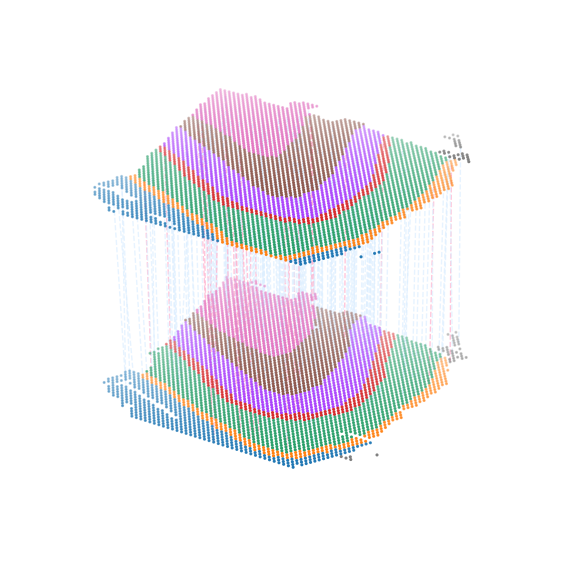

In [16]:
import seaborn as sns
embd0 = Batch_list_r[0].obsm['Graspot']
embd1 = Batch_list_r[1].obsm['Graspot']
adata1 = Batch_list_r[0]
adata2 = Batch_list_r[1]
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['Ground Truth']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['Ground Truth']})

multi_align = match_3D_multi(adata2_df, adata1_df, matching_plt[0], meta='celltype',
                            scale_coordinate=True, subsample_size=200)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

dataset1: 8 cell types; dataset2: 8 cell types; 
                    Total :8 celltypes; Overlap: 8 cell types 
                    Not overlap :[[]]
Subsample 200 cell pairs from 3592


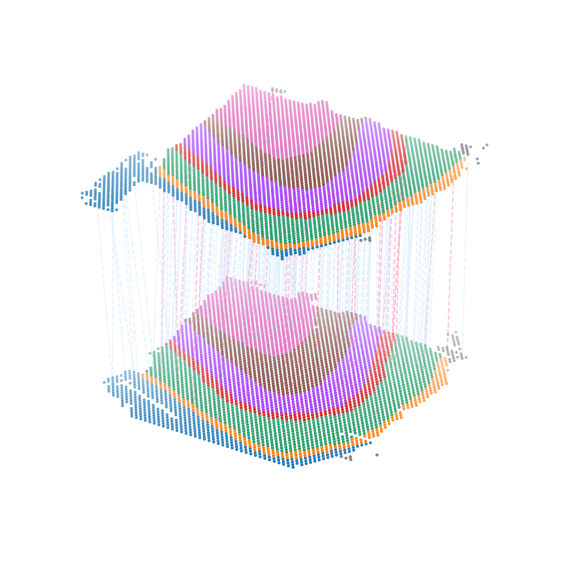

In [17]:
embd0 = Batch_list_r[1].obsm['Graspot']
embd1 = Batch_list_r[2].obsm['Graspot']
adata1 = Batch_list_r[1]
adata2 = Batch_list_r[2]
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['Ground Truth']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['Ground Truth']})

multi_align = match_3D_multi(adata1_df, adata2_df, matching_plt[1], meta='celltype',
                            scale_coordinate=True, subsample_size=200)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

dataset1: 8 cell types; dataset2: 8 cell types; 
                    Total :8 celltypes; Overlap: 8 cell types 
                    Not overlap :[[]]
Subsample 200 cell pairs from 3460


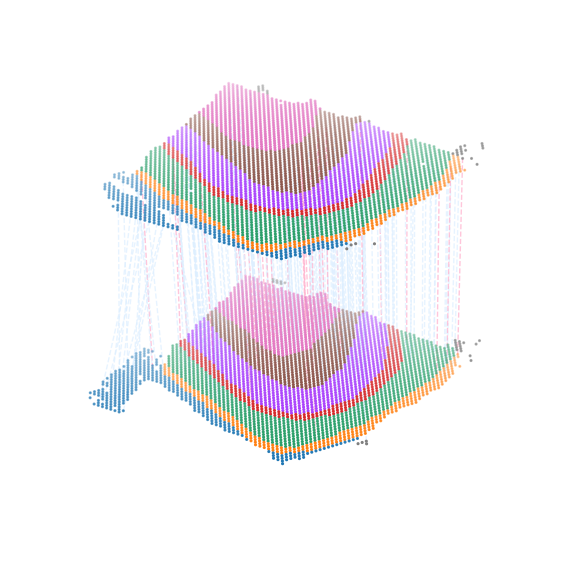

In [18]:
embd0 = Batch_list_r[2].obsm['Graspot']
embd1 = Batch_list_r[3].obsm['Graspot']
adata1 = Batch_list_r[2]
adata2 = Batch_list_r[3]
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['Ground Truth']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['Ground Truth']})

multi_align = match_3D_multi(adata1_df, adata2_df, matching_plt[2], meta='celltype',
                            scale_coordinate=True, subsample_size=200)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

In [4]:
import scipy.sparse as sp
Batch_list = []
adj_list = []
section_ids = ['151673','151674','151675','151676']
#section_ids = ['151673','151674']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('data/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674', '151675', '151676']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


In [5]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')

In [6]:
iter_comb = [(1, 2)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, Couple = None, device=used_device)

STAligner(
  (conv1): GATConv(1125, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1125, heads=1)
)
Train with STAligner...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:50<00:00,  3.94it/s]


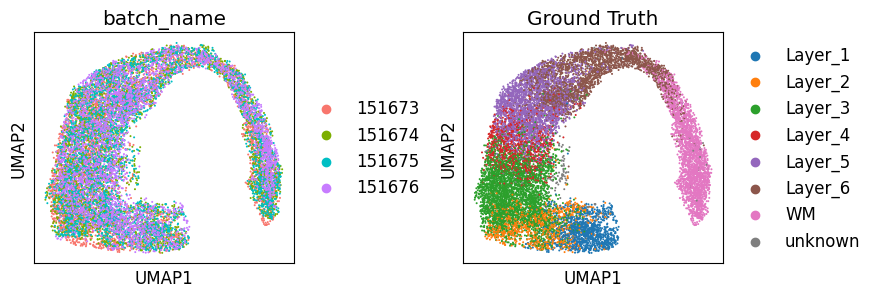

In [7]:
sc.pp.neighbors(adata_concat, use_rep='Graspot', random_state=2023)
sc.tl.umap(adata_concat, random_state=2023)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth'], ncols=3,
           wspace=0.5, show=True)

In [12]:
adata_concat

AnnData object with n_obs × n_vars = 14364 × 1125
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'slice_name', 'batch_name'
    uns: 'neighbors', 'umap', 'batch_name_colors', 'Ground Truth_colors', 'paga', 'Ground Truth_sizes'
    obsm: 'spatial', 'Graspot', 'X_umap'
    obsp: 'distances', 'connectivities'

<Axes: >

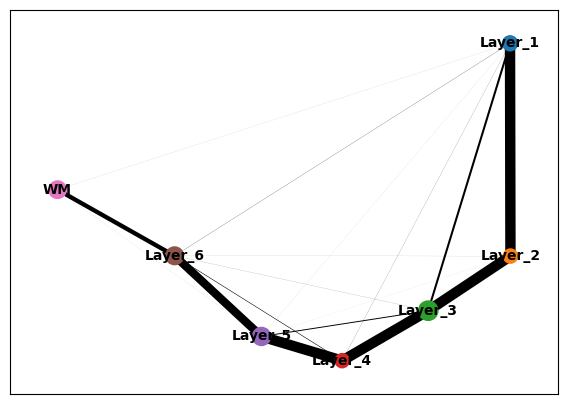

In [14]:
sc.pp.neighbors(adata_concat, use_rep='Graspot', random_state=2023)
adata_concat_know = adata_concat[adata_concat.obs['Ground Truth']!='unknown']
sc.tl.paga(adata_concat_know, groups='Ground Truth')
sc.pl.paga(adata_concat_know, color=['Ground Truth'],threshold=0,show=False)

In [13]:
adata_concat_know = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

<Axes: >

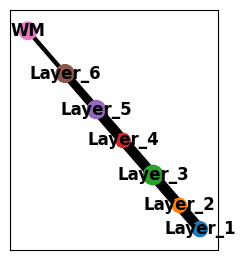

In [29]:
sc.tl.paga(adata_concat_know, groups='Ground Truth')
sc.pl.paga(adata_concat_know, color=['Ground Truth'],threshold=0.02,show=False)

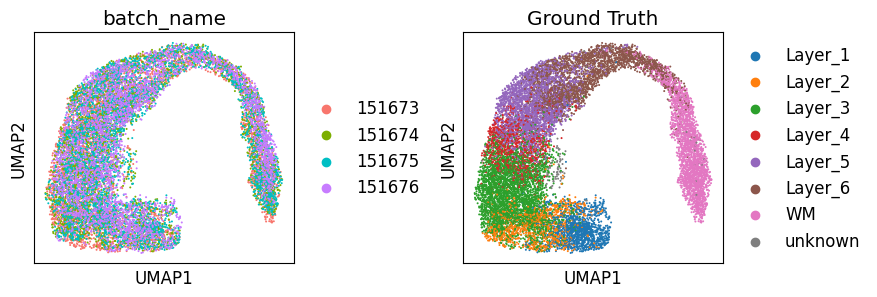

In [8]:
sc.pp.neighbors(adata_concat, use_rep='Graspot', random_state=2023)
sc.tl.umap(adata_concat, random_state=2023)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth'], ncols=3,
           wspace=0.5, show=True)

In [12]:
mapping_dict = {'Layer_1':1, 'Layer_2':2, 'Layer_3':3, 'Layer_4':4, 'Layer_5':5, 'Layer_6':6, 'WM':7}

In [13]:
heat_data1=np.array(np.matrix(Batch_list[1].obs['Ground Truth'].map(mapping_dict)))

In [14]:
for i in heat_data1:
    heat_data1_ = i

In [15]:
heat_data2=np.array(np.matrix(Batch_list[0].obs['Ground Truth'][matching_plt[0][1]].map(mapping_dict)))

In [16]:
matching_plt

[array([[   0,    1,    2, ..., 3589, 3590, 3591],
        [1889, 1510, 1064, ..., 3017,  523, 1724]])]

In [17]:
for j in heat_data2:
    heat_data2_ = j

In [15]:
import scipy.stats as stats
import math

In [18]:
heat_data1_

array([1., 3., 7., ..., 7., 6., 7.])

In [19]:
heat_data2_

array([1., 3., 7., ..., 7., 6., 7.])

In [20]:
loc1=[]
for i in range(len(heat_data1_)):
    if np.isnan(heat_data1_)[i]== True:
        loc1.append(i)
loc2=[]
for i in range(len(heat_data2_)):
    if np.isnan(heat_data2_)[i]== True:
        loc2.append(i)

In [21]:
merged_set = set(loc1 + loc2)
loc = list(merged_set)

In [22]:
loc11 = [x for x in list(range(len(heat_data1_))) if x not in loc]
loc22 = [x for x in list(range(len(heat_data2_))) if x not in loc]

In [23]:
new_lst_1=list(heat_data1_[loc11])
new_lst_2=list(heat_data2_[loc22])

In [27]:
from sklearn.metrics.cluster import adjusted_rand_score
#ARI_list = []
#for bb in range(4):
    #ARI_list.append(adjusted_rand_score(Batch_list_r[bb].obs['Ground Truth'], Batch_list_r[bb].obs['mclust']))
adjusted_rand_score(new_lst_1, new_lst_2)

0.6959158517751903

In [ ]:
adjusted_rand_score(Batch_list[0].obs['Ground Truth'], Batch_list[1].obs['Ground Truth'])

In [33]:
data_stat1=[]
data_stat2=[]
for i in range(len(new_lst_1)):
    data_stat1.append(int(new_lst_1[i]))
    data_stat2.append(int(new_lst_2[i]))

In [34]:
paired_samples_t_test_1_2 = stats.ttest_rel(new_lst_1, new_lst_2)
print("\n Here is paired_samples_t_test_1_2 result:\n", paired_samples_t_test_1_2)


 Here is paired_samples_t_test_1_2 result:
 TtestResult(statistic=-4.774414918889861, pvalue=1.873371876423807e-06, df=3634)

 Here is paired_samples_t_test_1_2 result:
 TtestResult(statistic=-4.774414918889861, pvalue=1.873371876423807e-06, df=3634)


In [6]:
iter_comb = [(0, 1)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, device=used_device)

STAligner(
  (conv1): GATConv(2341, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2341, heads=1)
)
Train with STAligner...


100%|████████████████████████████████████| 200/200 [00:54<00:00,  3.70it/s]


In [7]:
accuracy_in=[]
matching_plt=[]
getMax_plt=[]
for iters,comb in enumerate(iter_comb):
    i,j=comb[0],comb[1]
    result1 = pd.DataFrame(tran_list[iters].cpu().detach().numpy())
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=1)
        matching = np.array([np.arange(result1.shape[0]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        #np.put_along_axis(getMax,tran_list[iters].cpu().detach().numpy().argmax(1)[:,None],1,axis=1)
        for k in range(matching.shape[1]):
            x = int(matching[:,k][0])
            y = int(matching[:,k][1])
            getMax[x][y] = 1
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        matching_index = np.argmax(result1.to_numpy(),axis=0)
        matching = np.array([np.arange(result1.shape[1]),matching_index])
        getMax = np.zeros_like(tran_list[iters].cpu().detach().numpy())
        for k in range(matching.shape[1]):
            x = int(matching[:,k][1])
            y = int(matching[:,k][0])
            getMax[x][y] = 1
    matching_plt.append(matching)
    getMax_plt.append(getMax)
    
    accuracy_in.append(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))
    print(mapping_accuracy_in(Batch_list[i].obs['Ground Truth'], Batch_list[j].obs['Ground Truth'], getMax))

0.8582028029678483


In [8]:
matching_plt

[array([[   0,    1,    2, ..., 3636, 3637, 3638],
        [ 486, 2888,  767, ..., 3441, 3656, 2173]])]

In [1]:
from sklearn.metrics.cluster import adjusted_rand_score
#Batch_list[1].obs['Ground Truth'][matching_plt[0][1]]
for iters,comb in enumerate(iter_comb):
    if tran_list[iters].shape[0] < tran_list[iters].shape[1]:
        adjusted_rand_score(Batch_list[i].obs['Ground Truth'],Batch_list[j].obs['Ground Truth'][matching_plt[iters][0][1]])#第一个小第二个大
    if tran_list[iters].shape[0] > tran_list[iters].shape[1]:
        adjusted_rand_score(Batch_list[j].obs['Ground Truth'],Batch_list[i].obs['Ground Truth'][matching_plt[iters][0][1]])#第一个小第二个大

NameError: name 'iter_comb' is not defined

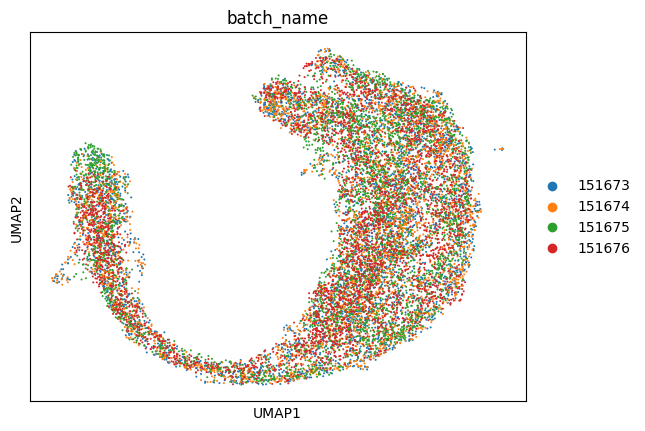

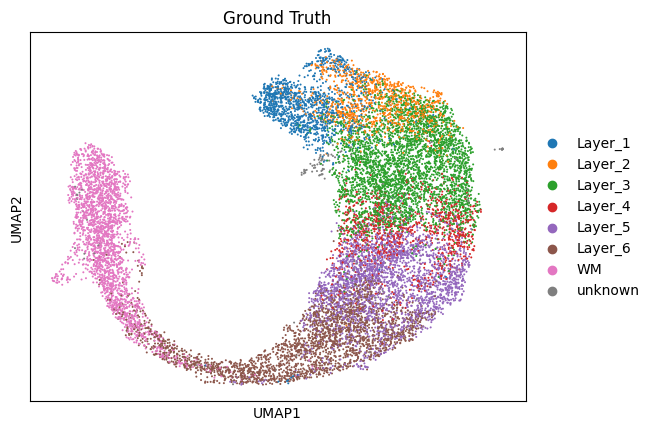

In [11]:
sc.pp.neighbors(adata_concat, use_rep='Graspot')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["batch_name"])
sc.pl.umap(adata_concat, color=["Ground Truth"])

In [12]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='Graspot', random_seed=2023):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    
    return adata

In [13]:
adata_concat = mclust_R(adata_concat, num_cluster=7, used_obsm='Graspot')

   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [14]:
Batch_list_r = Batch_list
for it in range(len(section_ids)):
    Batch_list_r[it].obs['mclust'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[it]].obs['mclust'] 

In [17]:
from sklearn.metrics.cluster import adjusted_rand_score
#ARI_list = []
#for bb in range(4):
    #ARI_list.append(adjusted_rand_score(Batch_list_r[bb].obs['Ground Truth'], Batch_list_r[bb].obs['mclust']))
adjusted_rand_score(Batch_list_r[0].obs['Ground Truth'], Batch_list_r[0].obs['mclust'])

0.5272985541742822

In [23]:
iter_comb = [(2, 3)]
adata_concat, tran_list = train_Graspot(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 200, iter_comb = iter_comb,
                                                        Batch_list=Batch_list, initial = True, device=used_device)

STAligner(
  (conv1): GATConv(1125, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1125, heads=1)
)
Train with STAligner...


100%|████████████████████████████████████| 200/200 [00:47<00:00,  4.18it/s]


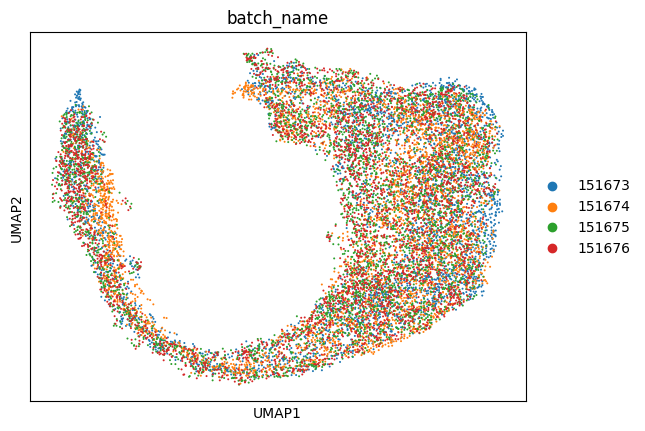

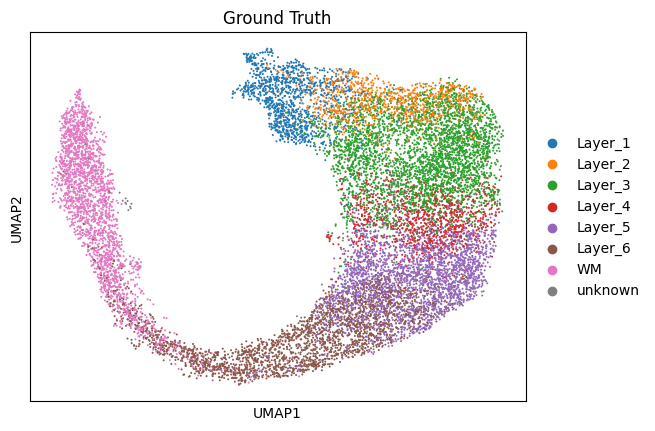

In [24]:
sc.pp.neighbors(adata_concat, use_rep='Graspot')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["batch_name"])
sc.pl.umap(adata_concat, color=["Ground Truth"])

In [25]:
adata_concat = mclust_R(adata_concat, num_cluster=7, used_obsm='Graspot')

fitting ...
  |======================================================================| 100%


In [26]:
Batch_list_r = Batch_list
for it in range(len(section_ids)):
    Batch_list_r[it].obs['mclust'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[it]].obs['mclust'] 

In [27]:
adjusted_rand_score(Batch_list_r[0].obs['Ground Truth'], Batch_list_r[0].obs['mclust'])

0.4053721223908426